<a href="https://colab.research.google.com/github/tezabhamidi/MWC_LISTA/blob/main/MWC_LISTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulated Wideband Converter: A Code-first tutorial

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import orthogonal_mp

# Define parameters
fs = 10000  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
N = len(t) # Length of original signal

# Define multiple frequency bands
freq1 = 100  # Frequency for the first band
freq2 = 500  # Frequency for the second band
freq3 = 1500 # Frequency for the third band

# Define parameters for MWC
fc = 750  # Center frequency of the band (Note: This parameter was used in the single-band example but not in the multi-band part)
BW = 200  # Bandwidth of the band
M = 8 # No of output bands

# Define sparsity level for OMP
sparsity_level_complex = 10 # Original signal has 3 frequencies, so 6 complex coeffs

# Calculate window size and downsampling factor based on parameters
window_size = int(fs / (2 * BW))
if window_size % 2 == 0:
    window_size += 1 # Ensure odd window size for centered filter

downsampling_factor = int(fs / (2 * BW)) # Sample at Nyquist rate of the filtered signal

## Signal generation function

Encapsulate the multi-band wideband signal generation and noise addition in a function.


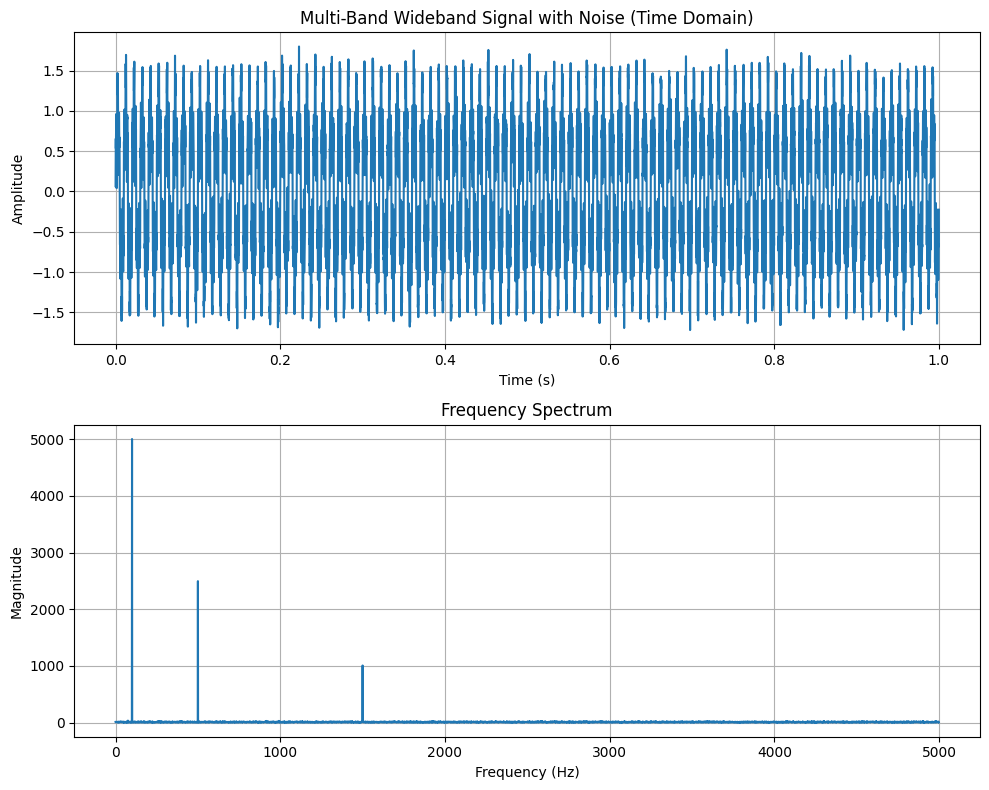

In [ ]:
def generate_wideband_signal(t, freq1, freq2, freq3, noise_amplitude):
    """
    Generates a multi-band wideband signal with added noise.

    Args:
        t (np.ndarray): Time vector.
        freq1 (float): Frequency for the first band.
        freq2 (float): Frequency for the second band.
        freq3 (float): Frequency for the third band.
        noise_amplitude (float): Amplitude of the random noise.

    Returns:
        tuple: A tuple containing:
            - wideband_signal (np.ndarray): The original multi-band signal without noise.
            - noisy_signal (np.ndarray): The multi-band signal with added noise.
    """
    # Generate signals for each band
    signal1 = np.sin(2 * np.pi * freq1 * t)
    signal2 = 0.5 * np.sin(2 * np.pi * freq2 * t)
    signal3 = 0.2 * np.sin(2 * np.pi * freq3 * t)

    # Combine the signals to create a multi-band wideband signal
    wideband_signal = signal1 + signal2 + signal3

    # Add noise to the signal
    noise = np.random.randn(len(t)) * noise_amplitude  # Generate random noise
    noisy_signal = wideband_signal + noise

    return wideband_signal, noisy_signal

# Call the function to generate the signals
noise_amplitude = 0.1 # Define noise amplitude
wideband_signal, noisy_signal = generate_wideband_signal(t, freq1, freq2, freq3, noise_amplitude)

# Calculate the Fast Fourier Transform (FFT)
fft_result = np.fft.fft(noisy_signal)
frequencies = np.fft.fftfreq(len(noisy_signal), 1/fs)

# Plot the time and frequency domains in subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Time Domain Plot
axes[0].plot(t, noisy_signal)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Multi-Band Wideband Signal with Noise (Time Domain)')
axes[0].grid(True)

# Frequency Domain Plot
# We plot the magnitude of the FFT and only the positive frequencies
axes[1].plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(fft_result)//2])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude')
axes[1].set_title('Frequency Spectrum')
axes[1].grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping titles/labels
plt.show()

## MWC sensing and Sensing Matrix Construction

Create a function that simulates the entire MWC process, taking the input signal and MWC parameters and returning the resampled measurements. This will incorporate the local oscillator generation, mixing, filtering, and downsampling.


In [ ]:
def simulate_mwc(input_signal, M, fs, BW, t, window_size, downsampling_factor, local_oscillators):
    """
    Simulates the Modulated Wideband Converter (MWC) process.

    Args:
        input_signal (np.ndarray): The input signal (e.g., noisy_signal or an IFFT basis vector).
        M (int): The number of MWC channels.
        fs (float): Sampling frequency.
        BW (float): Bandwidth of the band.
        t (np.ndarray): Time vector.
        window_size (int): The window size used for the low-pass filter.
        downsampling_factor (int): The factor used for downsampling.
        local_oscillators (np.ndarray): The local oscillator sequences to use.

    Returns:
        np.ndarray: A flattened array of the resampled measurements from all channels.
    """
    N_input = len(input_signal)

    # Mix the input signal with each local oscillator
    mixed_signals = input_signal * local_oscillators

    # Design a low-pass filter (moving average filter)
    low_pass_filter_kernel = np.ones(window_size) / window_size

    # Determine the expected length after convolution in 'valid' mode
    convolved_length = max(0, N_input - window_size + 1)
    # Determine the length after downsampling
    resampled_length_per_channel = convolved_length // downsampling_factor

    # Initialize array for resampled outputs
    resampled_outputs = np.zeros((M, resampled_length_per_channel), dtype=mixed_signals.dtype)

    for i in range(M):
        # Apply low-pass filter
        low_pass_filtered = np.convolve(mixed_signals[i, :], low_pass_filter_kernel, mode='valid')

        # Downsample
        downsampled_convolved = low_pass_filtered[::downsampling_factor]

        # Assign the downsampled signal to the pre-allocated array
        actual_downsampled_length = len(downsampled_convolved)
        if actual_downsampled_length > resampled_length_per_channel:
             resampled_outputs[i, :] = downsampled_convolved[:resampled_length_per_channel]
        else:
             resampled_outputs[i, :actual_downsampled_length] = downsampled_convolved

    # Flatten the resampled signals
    flattened_measurements = resampled_outputs.flatten()

    return flattened_measurements


def construct_sensing_matrix(M, fs, BW, t, N, window_size, downsampling_factor, local_oscillators_for_A):
    """
    Constructs the sensing matrix for the MWC system.

    Args:
        M (int): The number of MWC channels.
        fs (float): Sampling frequency.
        BW (float): Bandwidth of the band.
        t (np.ndarray): Time vector.
        N (int): Length of the original signal.
        window_size (int): The window size used for the low-pass filter.
        downsampling_factor (int): The factor used for downsampling.
        local_oscillators_for_A (np.ndarray): The specific local oscillator sequences
                                               to use for sensing matrix construction.

    Returns:
        np.ndarray: The constructed sensing matrix A.
        int: The total number of measurements.
    """
    # Determine the expected length after convolution in 'valid' mode
    # The length of the output of np.convolve(a, v, mode='valid') is max(0, len(a) - len(v) + 1).
    convolved_length = max(0, N - window_size + 1)
    # The length of the resampled signal in each channel based on the overall expected length
    resampled_length_per_channel = convolved_length // downsampling_factor

    num_measurements = M * resampled_length_per_channel

    if num_measurements <= 0:
         raise ValueError("Calculated number of measurements is zero or negative. Check parameters.")

    print(f"Expected shape of sensing matrix A: ({num_measurements}, {N})")

    sensing_matrix_A = np.zeros((num_measurements, N), dtype=complex)

    # Basis vectors for frequency domain (columns of inverse FFT matrix)
    fft_basis = np.fft.ifft(np.identity(N), axis=0) # Each column is a basis vector

    # Construct A column by column
    for k in range(N):
        # The k-th column of the inverse FFT matrix is the input signal representing
        # a single frequency component (k * fs / N).
        input_signal_k = fft_basis[:, k]

        # Simulate MWC for this input frequency component using the simulate_mwc function
        mwc_output_k = simulate_mwc(input_signal_k, M, fs, BW, t, window_size, downsampling_factor, local_oscillators_for_A)

        # Assign the MWC output as the k-th column of the sensing matrix A.
        if mwc_output_k.shape[0] != num_measurements:
            print(f"Error: MWC output shape mismatch for k={k}. Expected: {num_measurements}, Got: {mwc_output_k.shape[0]}")
            # Handle this error appropriately, e.g., by stopping or adjusting the simulation
            # For now, we'll break
            sensing_matrix_A = None # Indicate failure
            num_measurements = 0 # Indicate failure
            break

        sensing_matrix_A[:, k] = mwc_output_k

    return sensing_matrix_A, num_measurements

# Generate M independent PRBS local oscillator sequences ONCE for both the signal and sensing matrix
# It's crucial to use the SAME set of local oscillators for both.
local_oscillators = np.random.randint(0, 2, (M, N)) * 2 - 1

# Call the simulate_mwc function with the generated local oscillators
y = simulate_mwc(noisy_signal, M, fs, BW, t, window_size, downsampling_factor, local_oscillators)

# Call the new function to construct the sensing matrix A
sensing_matrix_A, actual_num_measurements = construct_sensing_matrix(M, fs, BW, t, N, window_size, downsampling_factor, local_oscillators)

# Update num_measurements with the actual calculated value from the function
num_measurements = actual_num_measurements

# Print the shape of the constructed sensing matrix A to verify the output.
if sensing_matrix_A is not None:
    print("Shape of the constructed sensing matrix A:", sensing_matrix_A.shape)
    # Ensure y (measurements) is also a flattened array for OMP (already done by the new simulate_mwc)
    print("Shape of measurements y:", y.shape) # y is the output of simulate_mwc from the previous step
else:
    print("Sensing matrix construction failed due to shape mismatch.")

Expected shape of sensing matrix A: (3192, 10000)
Shape of the constructed sensing matrix A: (3192, 10000)
Shape of measurements y: (3192,)


## Recovery by Orthogonal Matching Pursuit (OMP)

OMP algorithm, signal reconstruction, plotting of results, and MSE calculation in a single section.


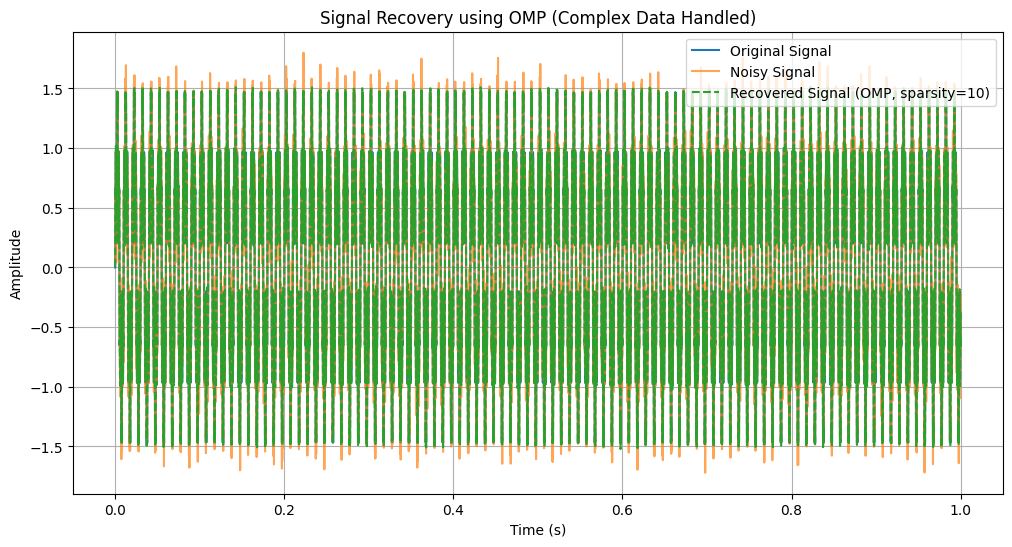

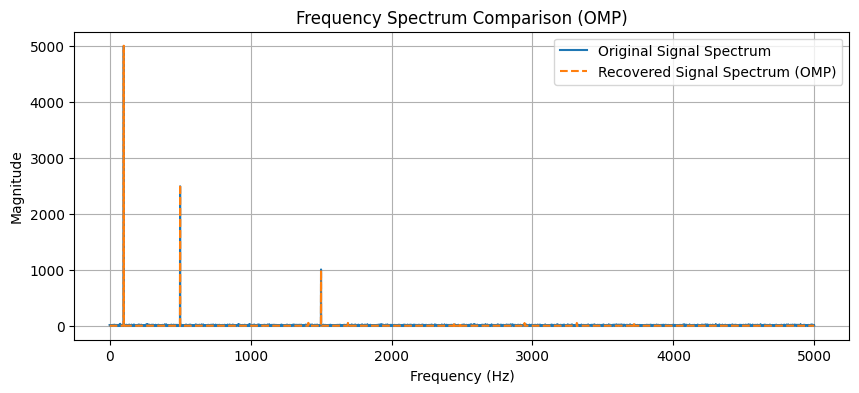

Mean Squared Error between Original and Recovered Signal (OMP): 0.00037155177486589277


In [ ]:
# Orthogonal Matching Pursuit (OMP) algorithm for signal recovery

# Prepare the stacked real matrices and vectors for OMP
# Ensure y is a 1D array for reshaping (already done by simulate_mwc function)
y_original = y.flatten()

# Get the real and imaginary parts of y
y_real = np.real(y_original)
y_imag = np.imag(y_original)

# Stack y_real and y_imag
y_stacked = np.concatenate((y_real, y_imag))

# Get the real and imaginary parts of the sensing matrix A
A_real = np.real(sensing_matrix_A)
A_imag = np.imag(sensing_matrix_A)

# Construct the stacked real sensing matrix Phi_stacked
Phi_stacked = np.block([[A_real, -A_imag],
                        [A_imag,  A_real]])

# Apply OMP to the real stacked system: y_stacked = Phi_stacked @ X_stacked
# We are solving for X_stacked = [x_r, x_i]^T.

# Define the sparsity level for the stacked real vector X_stacked.
# If the original complex vector x has K non-zero elements, the stacked vector X_stacked
# can have up to 2K non-zero elements (if both real and imaginary parts are non-zero).
# We use the sparsity_level_complex defined earlier.
sparsity_level_stacked = 2 * sparsity_level_complex # Max sparsity in stacked real vector

# Ensure sparsity_level_stacked does not exceed the number of features in Phi_stacked
num_features_stacked = Phi_stacked.shape[1]
if sparsity_level_stacked > num_features_stacked:
    print(f"Warning: Adjusted sparsity_level_stacked ({sparsity_level_stacked}) exceeds number of features ({num_features_stacked}). Setting to {num_features_stacked}.")
    sparsity_level_stacked = num_features_stacked

# Use orthogonal_mp for recovery on the real stacked system
# Handle potential errors if Phi_stacked is None due to construction failure
if Phi_stacked is not None:
    try:
        x_hat_stacked = orthogonal_mp(Phi_stacked, y_stacked, n_nonzero_coefs=sparsity_level_stacked)

        # The recovered vector x_hat_stacked contains the real and imaginary parts of the
        # estimated complex sparse coefficients, stacked: x_hat_stacked = [x_hat_r, x_hat_i]^T.

        # Separate the real and imaginary parts of the estimated coefficients
        num_coeffs_complex = N # Original number of frequency coefficients
        x_hat_real = x_hat_stacked[:num_coeffs_complex]
        x_hat_imag = x_hat_stacked[num_coeffs_complex:]

        # Reconstruct the complex sparse coefficient vector
        x_hat_omp_complex = x_hat_real + 1j * x_hat_imag

        # Recover the time-domain signal using inverse FFT
        # Apply inverse FFT to the estimated frequency coefficients
        recovered_signal_omp = np.fft.ifft(x_hat_omp_complex)

        # Take the real part for plotting and comparison.
        recovered_signal_omp_real = np.real(recovered_signal_omp)

        # Plot the original signal, noisy signal, and recovered signal
        plt.figure(figsize=(12, 6))
        plt.plot(t, wideband_signal, label='Original Signal')
        plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.7)
        # Ensure the time vector for the recovered signal matches the original
        plt.plot(t, recovered_signal_omp_real, label=f'Recovered Signal (OMP, sparsity={sparsity_level_complex})', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title('Signal Recovery using OMP (Complex Data Handled)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Compare the frequency spectrum of the recovered signal with the original
        recovered_fft = np.fft.fft(recovered_signal_omp_real)
        plt.figure(figsize=(10, 4))
        # Plot only the positive frequencies
        positive_frequencies = frequencies[:N//2]
        plt.plot(positive_frequencies, np.abs(fft_result)[:N//2], label='Original Signal Spectrum')
        plt.plot(positive_frequencies, np.abs(recovered_fft)[:N//2], label='Recovered Signal Spectrum (OMP)', linestyle='--')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('Frequency Spectrum Comparison (OMP)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Evaluate the recovery performance using Mean Squared Error
        # Ensure both signals have the same length before calculating MSE
        min_len = min(len(wideband_signal), len(recovered_signal_omp_real))
        mse = np.mean((wideband_signal[:min_len] - recovered_signal_omp_real[:min_len])**2)
        print(f"Mean Squared Error between Original and Recovered Signal (OMP): {mse}")

    except ValueError as e:
        print(f"Error during OMP recovery: {e}")
        print("Skipping OMP recovery and plotting due to error.")
else:
    print("Sensing matrix A is None. Skipping OMP recovery and plotting.")